# Economics Problem 3
### Navneeraj Sharma

### Question 3.1

### The Bellman equation is given by 

$$ V(k_{t},z_{t}) = \max_{c_t}  [u(c_{t})] + \beta E[V(k_{t+1},z_{t+1})]  $$

where

$$ c_{t} = (1-\delta)k_{t} + z_{t}k_{t}^\alpha - k_{t+1} $$

where 
$$ \ln(z_{t}) =  \rho\ln(z_{t-1}) + \nu_{t} $$

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import fminbound
import scipy.optimize as opt
import numba
import ar1_approx as ar1

# to print plots inline
%matplotlib inline

In [2]:
beta = 0.96
gamma = 0.50
delta =  0.05
alpha = 0.4
mu = 0.0
rho = 0.8
sigma_v = 0.10

'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital(k) grid
ub_k      = scalar, upper bound of capital(k) grid 
size_k    = integer, number of grid points in kapital state space
k_grid    = vector, size_w x 1 vector of cake grid points 
------------------------------------------------------------------------
'''
lb_k = 10.0
ub_k = 20.0 
size_k = 200  # Number of grid points for capital grid
size_eps = 200 # Number of grid points for shock grid
k_grid = np.linspace(lb_k, ub_k, size_k)
# Use the Adda Cooper method suggested by Jason
shock_z, trans_p =  ar1.addacooper(size_eps,mu, rho,sigma_v)
shock_grid = np.exp(shock_z)
prob = np.transpose(trans_p)

In [3]:
def utility(C,gamma):
    U = (C ** (1 - gamma)) / (1 - gamma)
    return U  

In [4]:
''' Create a three dimesional utility array with dimensions for k,k' and z.
Once the utility has been calculated at each of the value in this array. 
Take a mean value in the z dimension to get a 2-D array for Expected utility
'''
C =  np.zeros((size_k, size_k, size_eps))

@numba.jit
def C_loop(size_k,size_eps,delta,k_grid,shock_grid,alpha):
    for i in range(size_k): # loop over k
        for j in range(size_k): # loop over k'
            for s in range(size_eps): #loop over z shock
                C[i,j,s] =   (1-delta)*k_grid[i] + shock_grid[s]*k_grid[i]**alpha-k_grid[j]

    return C

C =  C_loop(size_k,size_eps,delta,k_grid,shock_grid,alpha)
C[C<0] = 1e-6
U = utility(C,gamma) 
U[C == 1e-6] = -1e6

## Step 2: Value Function Iteration

In [5]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of k , k, and shock'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of k' for all k 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8
VFdist = 7.0 
VFmaxiter = 5000 
V = np.zeros((size_k,size_eps) )# initial guess at value function
Vmat = np.zeros((size_k, size_k,size_eps)) # initialize Vmat matrix
Vstore = np.zeros((size_k,size_eps, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:
    @numba.jit
    def VFI_loop(size_k,Vmat,beta,V,size_eps,prob,U):
        for i in range(size_k): # loop over k
            for j in range(size_k): # loop over k'
                for s in range(size_eps):
                    EU = 0
                    for ss in range(size_eps):
                        EU += prob[s, ss]*V[j, ss]
                        Vmat[i, j,s] = U[i, j,s] + beta * EU
        return Vmat
    Vmat =  VFI_loop(size_k,Vmat,beta,V,size_eps,prob,U)
    Vstore[:,:, VFiter] = V.reshape(size_k,size_eps,) # store value function at each iteration for graphing later
    TV = Vmat.max(1) # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    print("Iteration ", VFiter, "dist =", VFdist)
    V = TV
    VFiter += 1 
    
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Iteration  1 dist = 7.580786726937896
Iteration  2 dist = 4.169617420960831
Iteration  3 dist = 3.598984241593948
Iteration  4 dist = 3.2474102739788986
Iteration  5 dist = 2.9830654852597434
Iteration  6 dist = 2.7679081465778452
Iteration  7 dist = 2.585535213789729
Iteration  8 dist = 2.4270320473809868
Iteration  9 dist = 2.28645369785216
Iteration  10 dist = 2.1598241565922685
Iteration  11 dist = 2.0455715940436576
Iteration  12 dist = 1.9417235821161825
Iteration  13 dist = 1.8465668487631746
Iteration  14 dist = 1.7587991763034907
Iteration  15 dist = 1.6773797350157764
Iteration  16 dist = 1.6014541478159217
Iteration  17 dist = 1.5303556590991434
Iteration  18 dist = 1.463513881390071
Iteration  19 dist = 1.4004700097440832
Iteration  20 dist = 1.3408434647788994
Iteration  21 dist = 1.2843152059150071
Iteration  22 dist = 1.230614559634617
Iteration  23 dist = 1.1795138333897768
Iteration  24 dist = 1.1308185687552665
Iteration  25 dist = 1.0843600013208459
Iteration  26 dis

Iteration  198 dist = 0.0009230398417940933
Iteration  199 dist = 0.0008861182481041396
Iteration  200 dist = 0.0008506735182010061
Iteration  201 dist = 0.0008166465775332199
Iteration  202 dist = 0.0007839807144023325
Iteration  203 dist = 0.0007526214857733748
Iteration  204 dist = 0.0007225166263822302
Iteration  205 dist = 0.000693615961353089
Iteration  206 dist = 0.0006658713229370505
Iteration  207 dist = 0.0006392364700218423
Iteration  208 dist = 0.0006136670111800413
Iteration  209 dist = 0.0005891203307157866
Iteration  210 dist = 0.0005655555175252402
Iteration  211 dist = 0.0005429332968134304
Iteration  212 dist = 0.0005212159649801151
Iteration  213 dist = 0.000500367326381479
Iteration  214 dist = 0.000480352633346115
Iteration  215 dist = 0.0004611385279957858
Iteration  216 dist = 0.0004426929869509877
Iteration  217 dist = 0.0004249852674718113
Iteration  218 dist = 0.0004079858567536121
Iteration  219 dist = 0.0003916664224732358
Iteration  220 dist = 0.00037599976

Iteration  383 dist = 4.846172316774755e-07
Iteration  384 dist = 4.6523250318841747e-07
Iteration  385 dist = 4.4662318998689443e-07
Iteration  386 dist = 4.2875831240962725e-07
Iteration  387 dist = 4.1160798502914986e-07
Iteration  388 dist = 3.9514367244919413e-07
Iteration  389 dist = 3.7933790508759557e-07
Iteration  390 dist = 3.6416437865227635e-07
Iteration  391 dist = 3.49597868876117e-07
Iteration  392 dist = 3.3561393308900733e-07
Iteration  393 dist = 3.2218937917605217e-07
Iteration  394 dist = 3.0930182504107506e-07
Iteration  395 dist = 2.969297554500372e-07
Iteration  396 dist = 2.8505259308531095e-07
Iteration  397 dist = 2.736505138045686e-07
Iteration  398 dist = 2.6270447506249184e-07
Iteration  399 dist = 2.5219628696504515e-07
Iteration  400 dist = 2.4210847016092885e-07
Iteration  401 dist = 2.3242414215474128e-07
Iteration  402 dist = 2.2312717362638068e-07
Iteration  403 dist = 2.1420214579848107e-07
Iteration  404 dist = 2.0563399516504433e-07
Iteration  405 

## Step 3: Extract decision rules from solution

In [6]:
'''Optimal Choice of k for next period and c'''
optk = k_grid[PF]
optc = (1-delta)*k_grid + shock_grid*k_grid**alpha- optk

## Visualize output

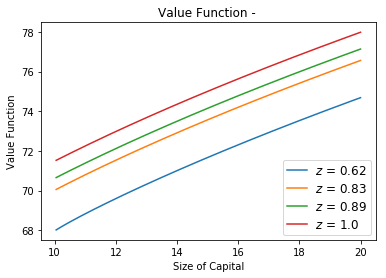

In [7]:
# Plot value function at several iterations
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:, 0], label='$z$ = ' + str(round(shock_grid[0],2)))
ax.plot(k_grid[1:], VF[1:, 25], label='$z$ = ' + str(round(shock_grid[25],2)))
ax.plot(k_grid[1:], VF[1:, 50], label='$z$ = ' + str(round(shock_grid[50],2)))
ax.plot(k_grid[1:], VF[1:, 99], label='$z$ = ' + str(round(shock_grid[99],2)))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Value Function')
plt.title('Value Function - ')
plt.show()

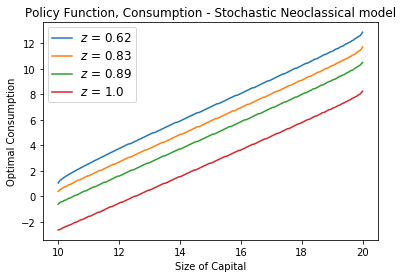

In [8]:
#Plot optimal consumption rule as a function of captal
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optc[:][0], label='$z$ = ' + str(round(shock_grid[0],2)))
ax.plot(k_grid[:], optc[:][25], label='$z$ = ' + str(round(shock_grid[25],2)))
ax.plot(k_grid[:], optc[:][50], label='$z$ = ' + str(round(shock_grid[50],2)))
ax.plot(k_grid[:], optc[:][99], label='$z$ = ' + str(round(shock_grid[99],2)))
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, Consumption - Stochastic Neoclassical model')
plt.show()

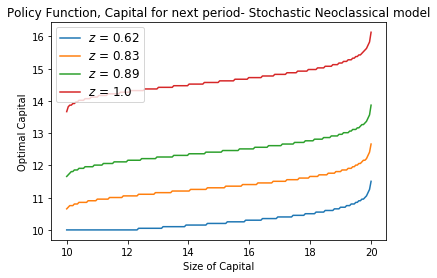

In [9]:
#Plot optimal capital next period rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
#ax.plot(k_grid[1:], optk[1:], label='Capital next period')
#ax.plot(k_grid[1:], k_grid[1:], '--', label='Y = X line')
ax.plot(k_grid[:], optk[:][0], label='$z$ = ' + str(round(shock_grid[0],2)))
ax.plot(k_grid[:], optk[:][25], label='$z$ = ' + str(round(shock_grid[25],2)))
ax.plot(k_grid[:], optk[:][50], label='$z$ = ' + str(round(shock_grid[50],2)))
ax.plot(k_grid[:], optk[:][99], label='$z$ = ' + str(round(shock_grid[99],2)))
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Optimal Capital')
plt.title('Policy Function, Capital for next period- Stochastic Neoclassical model')
plt.show()